**1. DATOS**

In [17]:
import os
from matplotlib import pyplot as plt   #Libreria que permite hacer plot
from PIL import Image #Procesamiento Digital de IMágenes PIL: Python Image Library
import numpy as np

In [36]:
if not os.path.exists('lfwcrop_grey'):

    !wget http://conradsanderson.id.au/lfwcrop/lfwcrop_grey.zip

    !unzip 'lfwcrop_grey.zip'

filenames = []
images = []

for filename in os.listdir('lfwcrop_grey/faces'):
    filenames.append(filename)
    image = np.array(Image.open(os.path.join('lfwcrop_grey/faces', filename)))
    images.append(image)

images = np.array(images)

print('Total Number of Faces: {}'.format(len(images)))
print(images.shape)
n = 64*64 #dimensión de mis datos (original) n = 4096 features
X = images.reshape(13233, n) # m = 13233 ejemplos de entrenamiento
print(X.shape)

Total Number of Faces: 13233
(13233, 64, 64)
(13233, 4096)




**2. VISUALIZACIÓN DE LAS IMÁGENES**

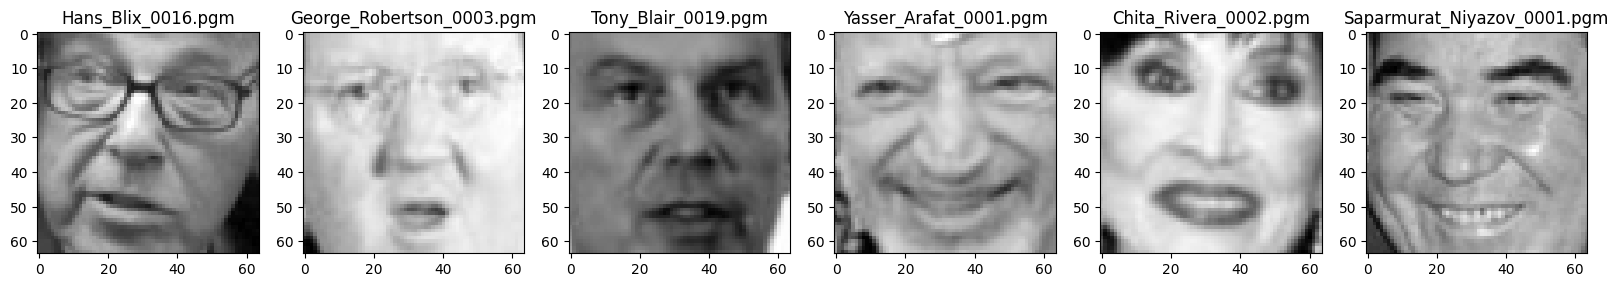

In [19]:
plt.figure(figsize=(20, 10))  #size de la imagen

num_images = 6 #Numero de imagenes
for i in range(num_images):

    plt.subplot(1, num_images, i+1)
    index = np.random.choice(range(len(images)))
    image = images[index]
    filename=filenames[index]
    plt.imshow(image, 'gray')  #que imprima en grises

    plt.title(filename)  #Imprima el nombre


**3. COMPRESION DE IMAGENES**



**Opción 1: COMPRESIÓN DE LAS IMÁGNES UTLIZANDO SVD**

Paso 1: Compresión de la Imagen (Reducción de la Dimensionalidad)


In [20]:
# SVD para PCA
print("Computando SVD...")
X_mean = np.mean(X, axis=0)  # Calcular la media de cada columna
X_centered = X - X_mean  # Centrar los datos
# Aplicar SVD
U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)  # SVD
# Determinar el número de componentes necesarios para retener al menos el 70% de la varianza
VR = 0.80  # Proporción mínima de varianza explicada deseada
explained_variance = S**2  # Varianza explicada proporcional a los valores singulares al cuadrado
total_variance = np.sum(explained_variance)  # Varianza total

# Sumar varianza explicada acumulada y determinar el número de componentes
cumulative_variance_ratio = np.cumsum(explained_variance) / total_variance
k = np.argmax(cumulative_variance_ratio >= VR) + 1  # Número de componentes necesarios
print(f"Número de componentes seleccionados para retener al menos el {VR*100}% de la varianza: {k}")

# Reducción de dimensionalidad usando los primeros k componentes
U_reduce = Vt[:k, :]  # Tomar las primeras k filas de Vt
Z = np.dot(X_centered, U_reduce.T)  # Proyectar los datos en el espacio reducido

# Mostrar los resultados
print("Dimensión original:", X.shape)
print("Dimensión reducida:", Z.shape)

# Verificar proporción de varianza explicada por k componentes
variance_retained = np.sum(explained_variance[:k]) / total_variance
print(f"Proporción de varianza explicada por {k} componentes: {variance_retained:.2f}")


Computando SVD...
Número de componentes seleccionados para retener al menos el 80.0% de la varianza: 33
Dimensión original: (13233, 4096)
Dimensión reducida: (13233, 33)
Proporción de varianza explicada por 33 componentes: 0.80


Paso 2: Reconstrucción de la Imagen

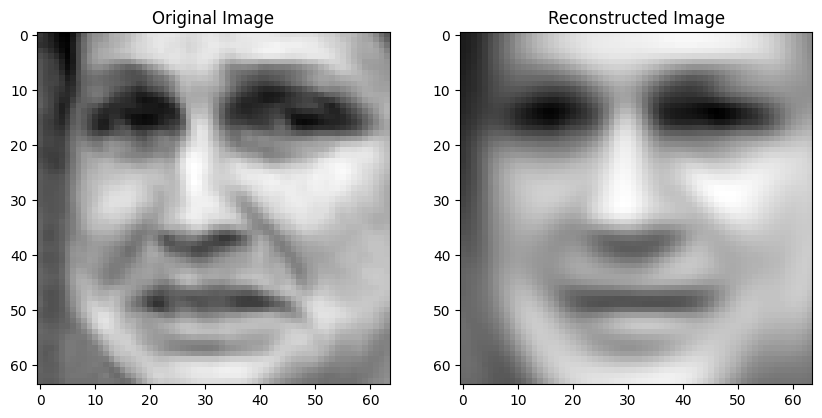

In [21]:
# Reconstrucción de los datos
X_approx = np.dot(Z, U_reduce) + X_mean  # Transformación inversa al espacio original

# Seleccionar una imagen aleatoria para graficar
np.random.seed(877)
index = np.random.randint(0,13233)    #Escoge un aleatorio entre 0 a 13233 imaenes
reconstructed_image = X_approx[index] # Reconstruir la imagen
reconstructed_image = reconstructed_image.reshape(64, 64)
original_image = images[index]  # Imagen original

# Mostrar la imagen original y la reconstruida
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(original_image, cmap='gray')

plt.subplot(1, 2, 2)
plt.title('Reconstructed Image')
plt.imshow(reconstructed_image, cmap='gray')

plt.show()

**Opción 2 (Simplificada): COMPRESIÓN DE LAS IMÁGNES UTLIZANDO DIRECTO EL COMANDO PCA**

Paso 1: Compresión de la Imagen (Reducción de la Dimensionalidad)


In [22]:
#Importar librerias
from sklearn import preprocessing
from sklearn.decomposition import PCA

explained_variance = 0.99 #varianza retenida =  varianza explicada = "información" retenida, la información que todavia se mantiene una vez comprimida la imagen
#Todos los componentes, retiene el 100%de la compresión, a medida que se reduce el tamaño se pierde información, se quiere retener el 99%de la información.

pca = PCA(explained_variance) #solo construyo el objeto pca, se usa la función, argumento dice que quiere que calcule para la información retenida el 0.99
pca.fit(X) #Implementa [U, S, V] = svd(Sigma); Ureduce = U(:,1:k) (ver diapositvas). Selecciona automáticamente k de modo que se retenga 99% de la varianza . Fit solo se hace en el training set.


#De cada 13233 de 64*64 = 4096 que son features, con el pca ahora disminuye a 577 features, disminuyendo la calidad de imagen.
z = pca.transform(X) # Implementa z = Ureduce'*x (ver diapositivas). En algebra lineal Ureduce o U son matrices de rotación

Ureduce = pca.components_.T #Ureduce nxk, reduciendo componentes principales

#puede demorar unos minutos
K = pca.n_components_

#Imprimir información
print("Los datos originales tienen dimensión", X.shape)
print("Los datos comprimidos tienen dimensión", z.shape)
print("El número de componentes principales K es", K, " que retienen el ", explained_variance*100, "% de la varianza")
print("El tam. de Ureduce (matriz de eigenvectors) es", Ureduce.shape)
print("PCA consigue reducir el tamaño en disco al ", K/n*100, "% de su tam. original")

Los datos originales tienen dimensión (13233, 4096)
Los datos comprimidos tienen dimensión (13233, 577)
El número de componentes principales K es 577  que retienen el  99.0 % de la varianza
El tam. de Ureduce (matriz de eigenvectors) es (4096, 577)
PCA consigue reducir el tamaño en disco al  14.0869140625 % de su tam. original


Paso 2: Reconstrucción de la Imagen

Label Jean_Charest_0015.pgm


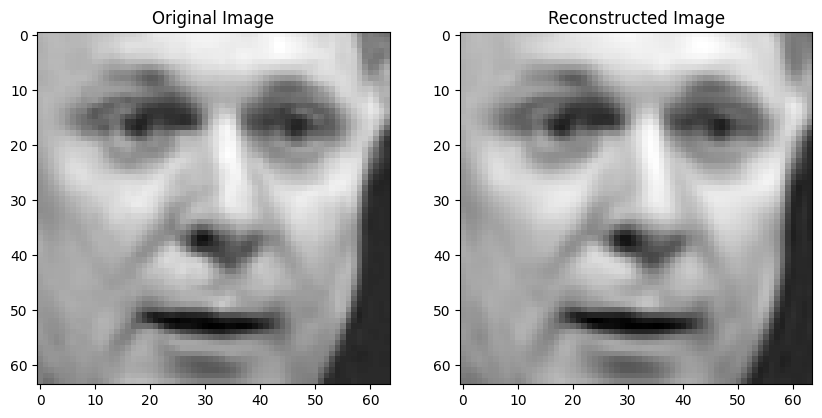

In [23]:
import random     #Se escoge 1 de todas las imagenes
random.seed(a=877)

#Implementa x_approx = Ureduce*z
X_approx = pca.inverse_transform(z) #transformada KL, Zscore por el PCA, no se usa el Ureduce ¨z ya se coloca la función
# índice de la imagen a graficar
index = random.randint(0,13233)    #Escoge un aleatorio entre 0 a 13233 imaenes
reconstructed_image = X_approx[index]
reconstructed_image = reconstructed_image.reshape(64, 64)
print('Label {}'.format(filenames[index]))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)    #Imprime 2 imagenes la original posicion 1
plt.title('Original Image')
plt.imshow(images[index], 'gray')

plt.subplot(1, 2, 2) #Imprime 2 imagenes la reconstruida posicion 1
plt.title('Reconstructed Image')
plt.imshow(reconstructed_image, 'gray')

**4. ACTIVIDADES DE LABORATORIO**

4.1 Varianza retenida vs Numero de componentes (k)

Grafique la varianza retenida en función del número de componentes principales retenidos k. Para esto, modifique la variable `explained_variance` con los siguientes valores: 0.99, 0.85, 0.7.

Para cada valor, verifique el número de componentes principales retenidos k. Además, imprimir lo siguiente por  pantalla:


1.   La dimensión de los datos comprimidos
2.   El número de componentes principales con su respectiva varianza retenida




In [24]:
from sklearn import preprocessing
from sklearn.decomposition import PCA
varianza = [0.99, 0.95, 0.90, 0.85, 0.80, 0.75, 0.7, 0.65, 0.6, 0.55, 0.50, 0.45, 0.40]
num_compo_k=[]

for x in varianza:
  #inserte el codigo aqui
  pca = PCA(x)
  pca.fit(X)
  num_compo_k.append(pca.n_components_)

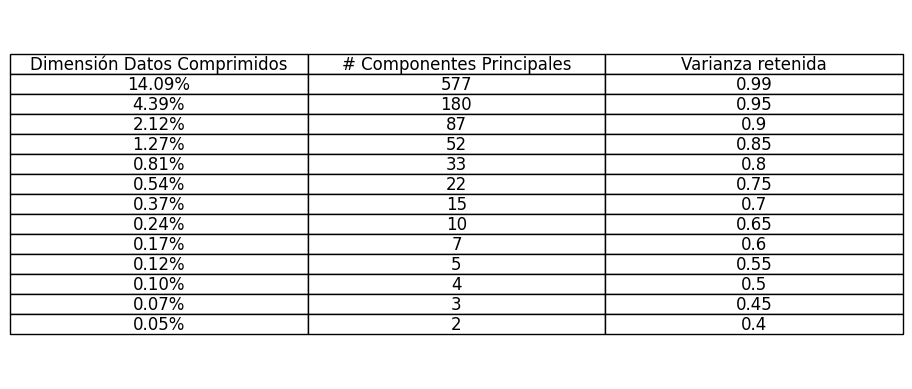

In [31]:
# Datos de la tabla
data = [
    ['Dimensión Datos Comprimidos', '# Componentes Principales', 'Varianza retenida']
]

for i in range(len(num_compo_k)):
  compressed_dimension = (num_compo_k[i]/n)*100
  row = [
      f"{compressed_dimension:.2f}%",
      num_compo_k[i],
      varianza[i]
  ]
  data.append(row)

fig, ax = plt.subplots()
ax.axis('off')
col_widths = [0.5, 0.5, 0.5]
table = ax.table(cellText=data, loc='center', cellLoc='center', colWidths=col_widths)
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)
plt.show()

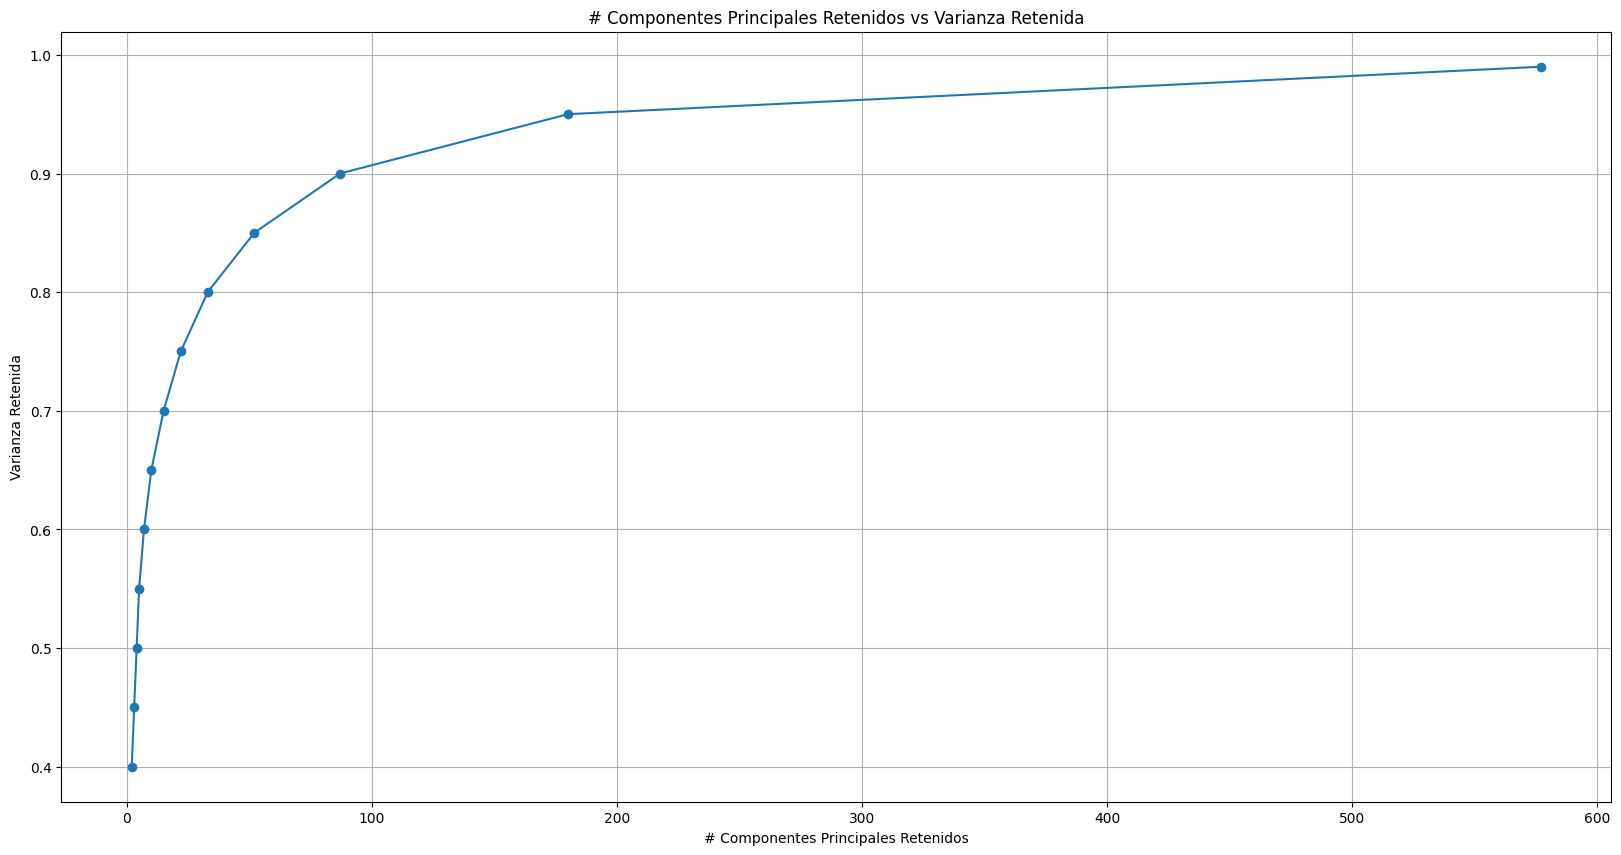

In [32]:
#aqui coloque su codigo para dibujar
plt.figure(figsize=(20, 10))
plt.plot(num_compo_k, varianza, marker='o')
plt.title("# Componentes Principales Retenidos vs Varianza Retenida")
plt.xlabel("# Componentes Principales Retenidos")
plt.ylabel("Varianza Retenida")
plt.grid()
plt.show()

* Como se observa tanto en la tabla como en la gráfica podemos concluir que a pesar de disminuir al 14% de información comprimida, con 577 componentes principales retenidos conservamos un 99% de la varianza de la información.
* A partir de 87 componentes principales conservamos el 90% de la varianza de la información y cada vez se hace más costoso ir incrementando la varianza retenida, ya que aumenta mucho el número de componentes principales necesarios para incrementos pequeños.
* Mientras con 2 componentes obtenemos una varianza retenida del 40%, para incrementar del 90% al 99% fue necesario adicionar 490 componentes principales

4.2 Compresión (número de componentes principales, k ) vs. calidad de imagen ( k/n)

# Grafique el porcentaje de compresión dado por k/n en función del número de componentes retenidos k. Para esto, modifique la variable `explained_variance` con los siguientes valores: 0.99, 0.85, 0.7.  Para cada valor, verifique el número de componentes princiaples retenidos k.

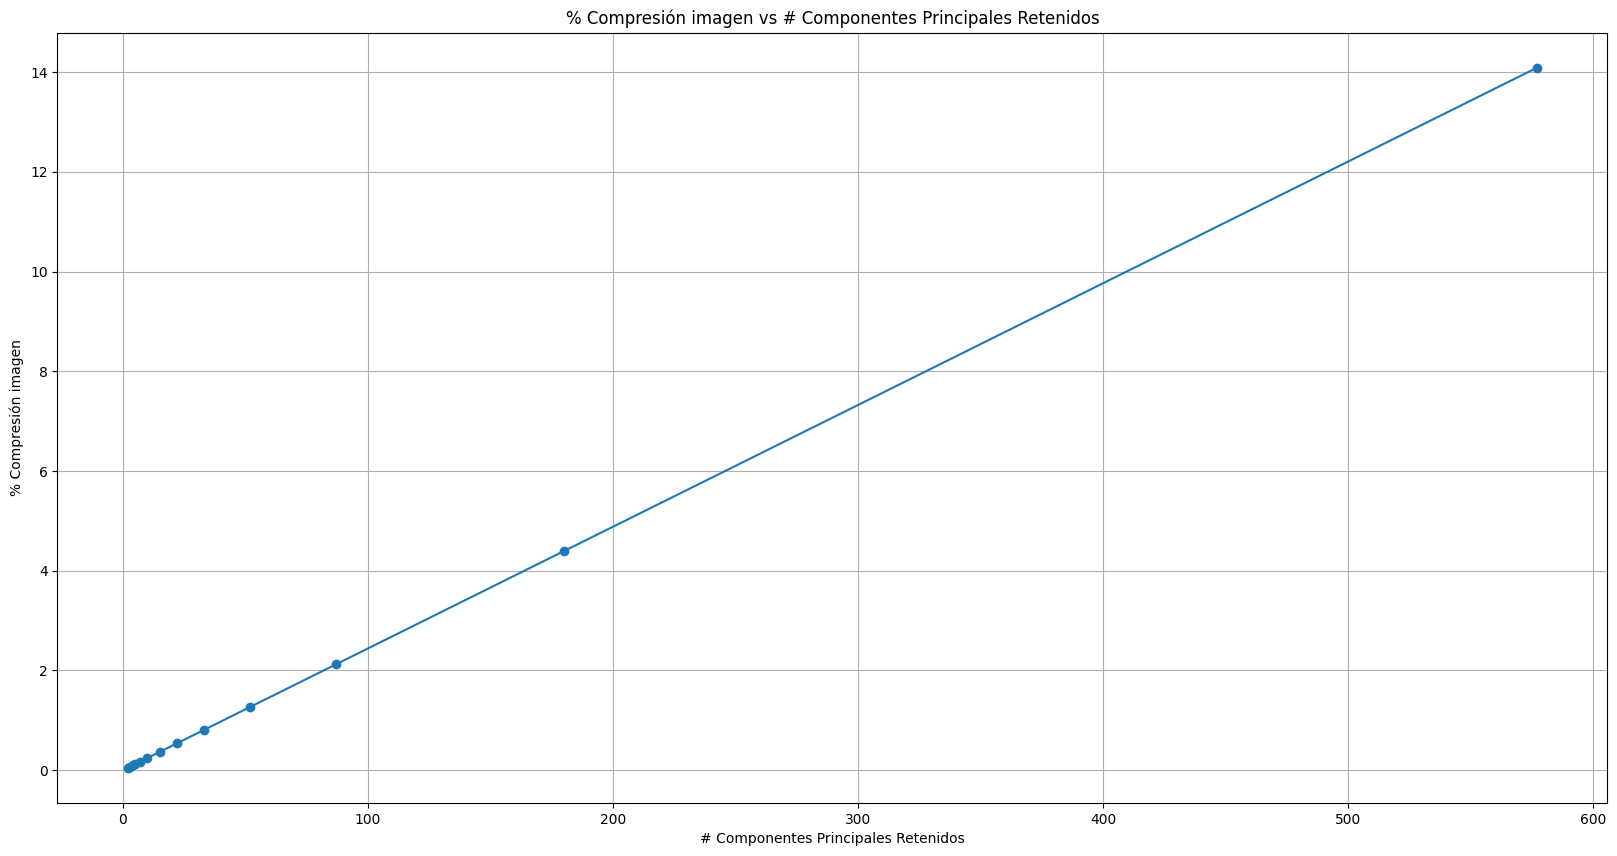

In [33]:
from sklearn import preprocessing
from sklearn.decomposition import PCA
#varianza = [0.99, 0.9, 0.8, 0.7]
calidad_imagen=[]

#for x in varianza:
   #Insertar el Código aqui
for k in num_compo_k:
  calidad_imagen.append(k/n*100)

#aqui codigo para dibujar
plt.figure(figsize=(20, 10))
plt.plot(num_compo_k, calidad_imagen, marker='o')
plt.title("% Compresión imagen vs # Componentes Principales Retenidos")
plt.xlabel("# Componentes Principales Retenidos")
plt.ylabel("% Compresión imagen")
plt.grid()
plt.show()


* En la gráfica se observa una relación lineal entre las varaibles de % compresión de imagen vs # componentes principales retenidos, ya que a medida que vamos incrementando el número de componentes principales, significa que hay más información que no será eliminada.
* Es un factor primordial definir la varianza retenida con la que se requiere trabajar, y en función de ella determinar número de componentes principales o % de información comprimida, ya que dependiendo el caso de aplicación, recursos disponibles se puede analizar con una gráfica similar si podemos seguir disminuyendo el % de información comprimida considerando que con ella perderemos calidad en la información.

# 4.3 Calidad vs Componente

# Variando el valor de k (componentes principales), grafique un rostro en particular (e.g., index=777), para ver la pérdida de calidad a medida que el número de componentes k disminuye. Para esto asumir `explained_variance` con los siguientes valores: 0.99, 0.7, 0.5, 0.2. Tenga en cuenta que, para cada valor de explined_variance se tiene un valor de componente principal K. Por ejemplo, para explained_variance=0.99, se tiene K=577.

In [37]:
#Insertar el Código
from sklearn import preprocessing
from sklearn.decomposition import PCA
varianza_exe3 = [0.99, 0.7, 0.5, 0.2]
K_exe3=[]
Z_exe3=[]
pca_exe3 = []

for x in varianza_exe3:
  #insertar codigo aqui
  current_pca = PCA(x)
  current_pca.fit(X)
  Z_exe3.append(current_pca.transform(X))
  K_exe3.append(current_pca.n_components_)
  pca_exe3.append(current_pca)

[577, 15, 4, 1]


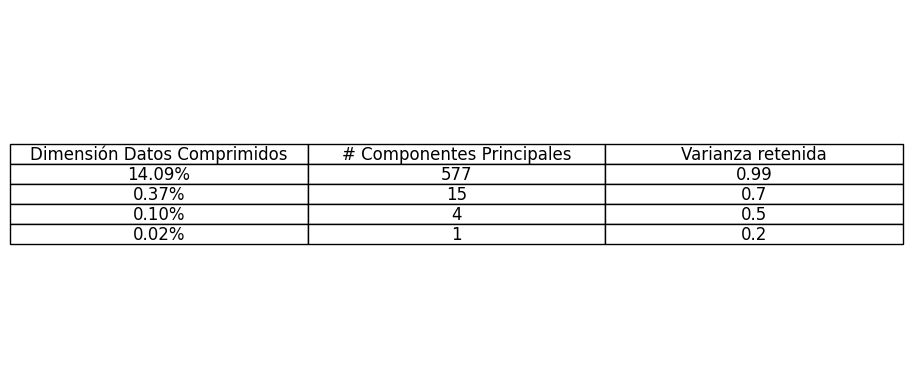

In [39]:
print(K_exe3)

# Datos de la tabla
data_images = [
    ['Dimensión Datos Comprimidos', '# Componentes Principales', 'Varianza retenida']
]

for i in range(len(varianza_exe3)):
  compressed_dimension = (K_exe3[i]/n)*100
  row = [
      f"{compressed_dimension:.2f}%",
      K_exe3[i],
      varianza_exe3[i]
  ]
  data_images.append(row)

fig, ax = plt.subplots()
ax.axis('off')
col_widths = [0.5, 0.5, 0.5]
table = ax.table(cellText=data_images, loc='center', cellLoc='center', colWidths=col_widths)
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)
plt.show()

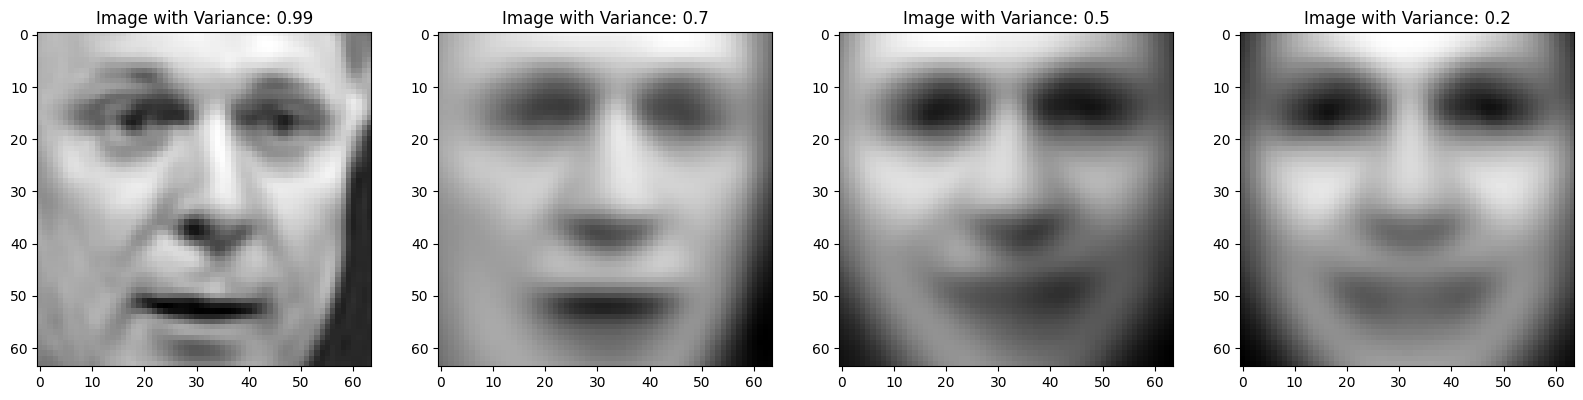

In [14]:
  # utillizar subplot para graficar cada imagen recuparada (approximada)
  # inserte su codigo
  #for z_item in Z_exe3:
  #  X_approx_exe3 = pca_exe3.inverse_transform(z_item)


import random     #Se escoge 1 de todas las imagenes
random.seed(a=877)
index = random.randint(0,13233)
plt.figure(figsize=(25,5))

for i in range(4):
    z_aux = Z_exe3[i]
    X_approx_exe31 = pca_exe3[i].inverse_transform(z_aux)
    reconstructed_image1 = X_approx_exe31[index]
    reconstructed_image1 = reconstructed_image1.reshape(64, 64)
    plt.subplot(1, 5, i+1)
    plt.title('Image with Variance: {}'.format(varianza_exe3[i]))
    plt.imshow(reconstructed_image1, 'gray')




* Como la varianza me indica el porcentaje de información o dispersión de los datos que se conserva de los datos originales, se puede observar que a mayor varianza, tengo una validad de imagen mejor, ya que conservo más información para poder reconstruir la información original. A medida que voy disminuyebdo la varianza, la calidad de la imagen también se ve afectada. Entonces, si tu objetivo es una compresión de imagen de alta calidad con mínima pérdida de información, es preferible retener un mayor número de componentes (cerca de 577 o varianza del 0.99). Sin embargo, si la reducción del tamaño es más importante, puedes permitirte retener menos componentes, pero a costa de perder más datos, como en el caso de la última imágen cuya varianza es del 0.2 y su respectivo # componentes principales es 1.

**CONCLUSIONES GENERALES**



1.   Colocar sus conclusiones y un comentario acerca de PCA o SVD

* SVD es la base matemática de PCA.
* Ambas son técnicas muy útiles que reducen las dimensiones de conjuntos de datos, como por ejemplo en el caso de "Opción 2 Simplificada" donde se pudo reconstruir una imagen prácticamente similar a la original reduciendo el tamaño en disco al 14% de su tamaño original. Lo que permite optimización de recursos.
* Permiten identificar features que en realidad no están aportando información relevante con respecto a otro que aporta la misma información, lo que permite reducir el número de features mientras se preserva la mayor cantidad de varianza posible en los datos.
* Debido a que existe esta reducción de dimensionalidad, la matriz resultante que permite la reconstrucción de los datos, nunca va a ser exactamente igual a la matriz original.


